# Projeto Final de Ciência de Dados

## Bibliotecas

In [20]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt

## Introdução

Nome dos integrantes:

- **Nome**: Alan Teixeira da Costa, **Matrícula**: 2022100890, **E-mail**: alan.costa@edu.ufes.br
- **Nome**: Miguel Vieira Machado Pim, **Matrícula**: 2022100894, **E-mail**: miguel.pim@edu.ufes.br

Neste projeto final iremos praticar os conceitos estudados durante toda a disciplina de Introdução a Ciência de Dados como: Análise de Dados, Web scraping, clusterização, entre outros. Para isso iremos fazer scraping de dados do site https://www.transfermarkt.com.br/ para poder estudar e analisar as competições de caráter eliminatório (Copa do Brasil) e de pontos corridos (Brasileirão).

## Descrição de Problema

O nosso problema consiste em analisar se os fatores (variáveis) que influenciam um time a ter uma boa colocação em um campeonato de pontos são os mesmos que em uma competição mata-mata. Para isso consideraremos uma boa colocação nos pontos corridos sendo o G4 (quatro primeiras posições) e no mata-mata, ter chegado as fases de semi-finais.

## Descrição do Conjunto de Dados

## Metodologia

## Scapring de dados

Definindo cabeçalho

In [2]:
headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36"}

### Brasileirão

Definindo url de busca por dados do Brasileirão

In [3]:
# Brasileirão
url = "https://www.transfermarkt.com.br/campeonato-brasileiro-serie-a/tabelle/wettbewerb/BRA1/saison_id/"

In [4]:
resultados_brasileirao = {
    'Ano': [],
    'Posicao': [],
    'Nome': [],
    'Jogos': [],
    'Vitorias': [],
    'Empates': [],
    'Derrotas': [],
    'Gols': [],
    'SG': [],
    'Pontos': []
}

In [5]:
for ano in range(2024, 2000, -1):
    print("Obtendo", ano, "...")

    page_url = url + str(ano - 1)

    res = requests.get(url=page_url, headers=headers)

    pageSoup = BeautifulSoup(res.content, 'html.parser')

    tables = pageSoup.find_all("table", {"class": "items"})

    table_rows = tables[0].find_all("tbody")[0].find_all("tr")

    for row in table_rows:
        line = row.find_all("td")

        resultados_brasileirao['Ano'].append(ano)
        resultados_brasileirao['Posicao'].append(line[0].text)
        resultados_brasileirao['Nome'].append(line[2].text.strip())
        resultados_brasileirao['Jogos'].append(line[3].text)
        resultados_brasileirao['Vitorias'].append(line[4].text)
        resultados_brasileirao['Empates'].append(line[5].text)
        resultados_brasileirao['Derrotas'].append(line[6].text)
        resultados_brasileirao['Gols'].append(line[7].text)
        resultados_brasileirao['SG'].append(line[8].text)
        resultados_brasileirao['Pontos'].append(line[9].text)

Obtendo 2024 ...
Obtendo 2023 ...
Obtendo 2022 ...
Obtendo 2021 ...
Obtendo 2020 ...
Obtendo 2019 ...
Obtendo 2018 ...
Obtendo 2017 ...
Obtendo 2016 ...
Obtendo 2015 ...
Obtendo 2014 ...
Obtendo 2013 ...
Obtendo 2012 ...
Obtendo 2011 ...
Obtendo 2010 ...
Obtendo 2009 ...
Obtendo 2008 ...
Obtendo 2007 ...
Obtendo 2006 ...
Obtendo 2005 ...
Obtendo 2004 ...
Obtendo 2003 ...
Obtendo 2002 ...
Obtendo 2001 ...


In [6]:
df_brasileirao = pd.DataFrame(resultados_brasileirao)
df_brasileirao.head()

,Ano,Posicao,Nome,Jogos,Vitorias,Empates,Derrotas,Gols,SG,Pontos
0,2024,1,Botafogo,38,23,10,5,59:29,30,79
1,2024,2,Palmeiras,38,22,7,9,60:33,27,73
2,2024,3,Flamengo,38,20,10,8,61:42,19,70
3,2024,4,Fortaleza,38,19,11,8,53:39,14,68
4,2024,5,Internacional,38,18,11,9,53:36,17,65


In [12]:
df_brasileirao.shape

(504, 10)

Vizualizando o dataframe

Text(0, 0.5, 'Quantidade de times')

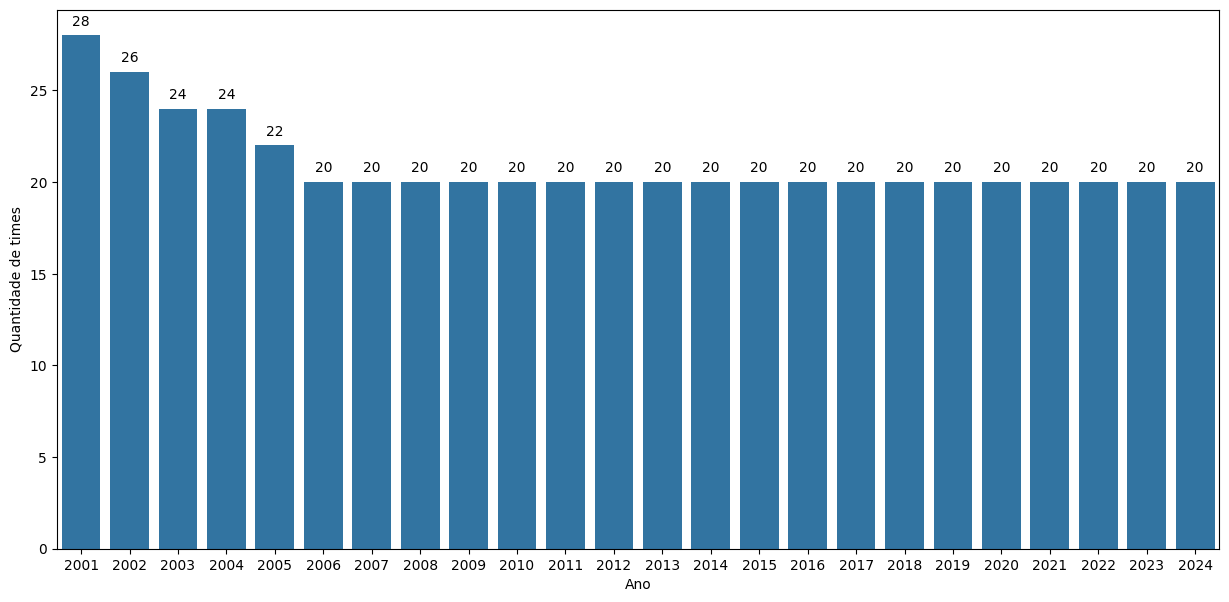

In [26]:
df_brasileirao_grouped_by_year = df_brasileirao.groupby("Ano")["Nome"].nunique()

fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(df_brasileirao_grouped_by_year, ax=ax)

for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=5)
    
plt.ylabel("Quantidade de times")

### Copa do Brasil

Definindo url de busca por dados da Copa do Brasil

In [7]:
# Copa do Brasil
url = "https://www.transfermarkt.com.br/copa-do-brasil/gesamtspielplan/pokalwettbewerb/BRC/saison_id/"

In [8]:
resultados_copa_do_brasil = {
    'Ano': [],
    'Fase': [],
    'TimeCasa': [],
    'Placar': [],
    'TimeFora': []
}

In [9]:
for ano in range(2024, 2000, -1):
    print("Obtendo", ano, "...")

    page_url = url + str(ano - 1)

    res = requests.get(url=page_url, headers=headers)

    pageSoup = BeautifulSoup(res.content, 'html.parser')
    
    tables = pageSoup.find_all("table")
    if not tables:
        print(f"\tNenhuma table encontrada para o ano {ano}")
        continue
    
    tables_stages = tables[1].find_all("tbody")
    if not tables_stages:
        print(f"\tNenhum tbody encontrado para o ano {ano}")
        continue
    
    for stages in tables_stages:
        table_rows = stages.find_all("tr")
        
        fase = table_rows[0].find_all("td")[0].text.strip()
        
        for row in table_rows:
            if row.has_attr("class"):
                continue
            
            line = row.find_all("td")
            
            if len(line) < 8:
                print(f"Linha ignorada (menos de 8 colunas): {line}")
                continue
            
            resultados_copa_do_brasil["Ano"].append(ano)
            resultados_copa_do_brasil["Fase"].append(fase)
            resultados_copa_do_brasil["TimeCasa"].append(line[3].text.strip())
            resultados_copa_do_brasil["Placar"].append(line[5].text.strip())
            resultados_copa_do_brasil["TimeFora"].append(line[7].text.strip())

Obtendo 2024 ...
Obtendo 2023 ...
Obtendo 2022 ...
Obtendo 2021 ...
Obtendo 2020 ...
Obtendo 2019 ...
Obtendo 2018 ...
Obtendo 2017 ...
Obtendo 2016 ...
Obtendo 2015 ...
Obtendo 2014 ...
Obtendo 2013 ...
Obtendo 2012 ...
Obtendo 2011 ...
Obtendo 2010 ...
Obtendo 2009 ...
Obtendo 2008 ...
Obtendo 2007 ...
Obtendo 2006 ...
Obtendo 2005 ...
Obtendo 2004 ...
Obtendo 2003 ...
Obtendo 2002 ...
Obtendo 2001 ...


In [10]:
df_copa_do_brasil = pd.DataFrame(resultados_copa_do_brasil)
df_copa_do_brasil.head()

,Ano,Fase,TimeCasa,Placar,TimeFora
0,2024,1ª eliminatória,Porto Velho,1:0,Remo
1,2024,1ª eliminatória,Nova Venécia,1:2,Botafogo-SP
2,2024,1ª eliminatória,Real Brasília,2:1,São Raimundo-RR
3,2024,1ª eliminatória,River-PI,1:1,Ypiranga-RS
4,2024,1ª eliminatória,Manauara,1:2,Retrô


In [11]:
df_copa_do_brasil.shape

(2975, 5)

## Pré-processamento dos dados

Já temos os dataframes em mãos mas agora precisamos pré-processar eles, deixando apenas aquilo que importa

### Brasileirão

In [13]:
df_brasileirao.head()

,Ano,Posicao,Nome,Jogos,Vitorias,Empates,Derrotas,Gols,SG,Pontos
0,2024,1,Botafogo,38,23,10,5,59:29,30,79
1,2024,2,Palmeiras,38,22,7,9,60:33,27,73
2,2024,3,Flamengo,38,20,10,8,61:42,19,70
3,2024,4,Fortaleza,38,19,11,8,53:39,14,68
4,2024,5,Internacional,38,18,11,9,53:36,17,65


Adicionando duas colunas: GP (Gols Pró) e GC (Gols Contra)

In [15]:
df_brasileirao[["GP", "GC"]] = df_brasileirao["Gols"].str.split(':', expand=True).astype(int)
df_brasileirao.head()

,Ano,Posicao,Nome,Jogos,Vitorias,Empates,Derrotas,Gols,SG,Pontos,GP,GC
0,2024,1,Botafogo,38,23,10,5,59:29,30,79,59,29
1,2024,2,Palmeiras,38,22,7,9,60:33,27,73,60,33
2,2024,3,Flamengo,38,20,10,8,61:42,19,70,61,42
3,2024,4,Fortaleza,38,19,11,8,53:39,14,68,53,39
4,2024,5,Internacional,38,18,11,9,53:36,17,65,53,36


Retirando colunas desnecessárias

In [18]:
new_df_brasileirao = df_brasileirao.drop(columns=["Posicao", "Nome", "Gols"], inplace=False)
new_df_brasileirao.head()

,Ano,Jogos,Vitorias,Empates,Derrotas,SG,Pontos,GP,GC
0,2024,38,23,10,5,30,79,59,29
1,2024,38,22,7,9,27,73,60,33
2,2024,38,20,10,8,19,70,61,42
3,2024,38,19,11,8,14,68,53,39
4,2024,38,18,11,9,17,65,53,36


### Copa do Brasil

In [14]:
df_copa_do_brasil.head()

,Ano,Fase,TimeCasa,Placar,TimeFora
0,2024,1ª eliminatória,Porto Velho,1:0,Remo
1,2024,1ª eliminatória,Nova Venécia,1:2,Botafogo-SP
2,2024,1ª eliminatória,Real Brasília,2:1,São Raimundo-RR
3,2024,1ª eliminatória,River-PI,1:1,Ypiranga-RS
4,2024,1ª eliminatória,Manauara,1:2,Retrô


## Resultados

## Conclusões e Discussões